In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10004059802032841200
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15134713447
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13138026540331066339
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv('./train.csv')
print("size of train_df:", len(train_df))

# 데이터 노이즈 수정
train_df.loc[train_df['id'] == 3896, 'artist'] = 'Titian'
train_df.loc[train_df['id'] == 3986, 'artist'] = 'Alfred Sisley'

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    validation_split=0.10
) # Train / Validation

TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="training"
)

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="validation"
)

size of train_df: 5911
Found 5320 validated image filenames belonging to 50 classes.
Found 591 validated image filenames belonging to 50 classes.


In [4]:
df = train_df.copy()
df['artist'].apply(lambda s: str(s).split('|'))
label_freq = df['artist'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)
display(label_freq)

Vincent van Gogh             629
Edgar Degas                  490
Pablo Picasso                303
Pierre-Auguste Renoir        233
Albrecht Du rer              220
Paul Gauguin                 220
Francisco Goya               204
Rembrandt                    181
Titian                       173
Marc Chagall                 173
Alfred Sisley                164
Paul Klee                    142
Rene Magritte                137
Amedeo Modigliani            132
Andy Warhol                  132
Henri Matisse                121
Sandro Botticelli            120
Mikhail Vrubel               118
Hieronymus Bosch             115
Leonardo da Vinci            101
Salvador Dali                 99
Peter Paul Rubens             97
Kazimir Malevich              91
Pieter Bruegel                85
Frida Kahlo                   84
Diego Velazquez               81
Joan Miro                     76
Andrei Rublev                 74
Raphael                       73
Giotto di Bondone             72
Gustav Kli

In [5]:
artist_df = df.copy()
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(df['artist'].values)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dic = {i: class_weights[i] for i in range(len(class_weights))}
class_weights_dic

{0: 0.5373636363636364,
 1: 0.7208536585365853,
 2: 0.8956060606060606,
 3: 1.5975675675675676,
 4: 0.8956060606060606,
 5: 1.8471875,
 6: 3.694375,
 7: 2.003728813559322,
 8: 2.3644,
 9: 1.4595061728395062,
 10: 0.24126530612244898,
 11: 1.906774193548387,
 12: 2.686818181818182,
 13: 1.8187692307692307,
 14: 4.546923076923077,
 15: 0.5795098039215686,
 16: 1.4073809523809524,
 17: 3.9406666666666665,
 18: 1.6419444444444444,
 19: 1.7133333333333334,
 20: 2.814761904761905,
 21: 0.9770247933884297,
 22: 2.2734615384615386,
 23: 1.9380327868852458,
 24: 1.028,
 25: 5.62952380952381,
 26: 1.8471875,
 27: 1.5555263157894736,
 28: 1.299120879120879,
 29: 1.1704950495049504,
 30: 0.6833526011560693,
 31: 3.4770588235294118,
 32: 1.001864406779661,
 33: 0.39016501650165014,
 34: 3.5824242424242425,
 35: 0.5373636363636364,
 36: 0.8325352112676057,
 37: 1.218762886597938,
 38: 0.5073819742489271,
 39: 2.003728813559322,
 40: 1.3908235294117648,
 41: 1.6194520547945206,
 42: 0.653149171270718

In [6]:
# ResNet50 모델 로드
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(244, 244, 3), pooling=None, input_tensor=None)

# 새로운 Fully Connected Layer 추가
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x) # 드롭아웃 추가
predictions = Dense(50, activation='softmax')(x)

#전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer=Adam(lr=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
CP = ModelCheckpoint(filepath='googlenet_model/' + 'GOOGLENET-Sigmoid-{epoch:03d}-{accuracy:.4f}-{val_loss:.4f}.hdf5',
                     monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.00005)
CALLBACK = [CP, LR]

In [8]:
# 모델 학습
history = model.fit(
    TRAIN_GENERATOR,
    epochs=20,
    shuffle=True,
    validation_data=VALID_GENERATOR,
    class_weight=class_weights_dic
)

Train for 167 steps, validate for 19 steps
Epoch 1/20
167/167 [==============================] - 147s 882ms/step - loss: 3.1073 - accuracy: 0.2748 - val_loss: 4.3301 - val_accuracy: 0.1472
Epoch 2/20
167/167 [==============================] - 115s 686ms/step - loss: 1.8077 - accuracy: 0.5055 - val_loss: 3.7661 - val_accuracy: 0.2555
Epoch 3/20
167/167 [==============================] - 115s 688ms/step - loss: 1.3772 - accuracy: 0.6100 - val_loss: 2.8257 - val_accuracy: 0.3858
Epoch 4/20
167/167 [==============================] - 114s 681ms/step - loss: 1.0729 - accuracy: 0.6789 - val_loss: 2.4068 - val_accuracy: 0.4839
Epoch 5/20
167/167 [==============================] - 222s 1s/step - loss: 0.9039 - accuracy: 0.7312 - val_loss: 2.7191 - val_accuracy: 0.4552
Epoch 6/20
167/167 [==============================] - 124s 743ms/step - loss: 0.7376 - accuracy: 0.7735 - val_loss: 2.3797 - val_accuracy: 0.5025
Epoch 7/20
167/167 [==============================] - 115s 687ms/step - loss: 0.6170

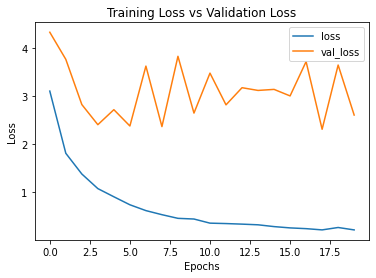

In [9]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

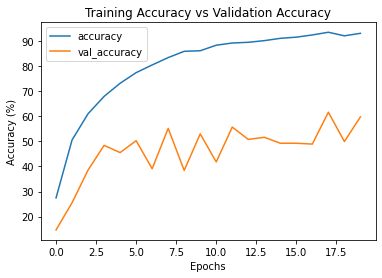

In [10]:
# 정확도 그래프
plt.plot([x * 100 for x in history.history['accuracy']])
plt.plot([x * 100 for x in history.history['val_accuracy']])
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [11]:
# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('googlenet_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

# Validation 데이터에 대한 정확도 확인
val_loss, val_accuracy = model.evaluate(VALID_GENERATOR)
print('Validation Loss:', round(val_loss, 6))
print('Validation Accuracy:', round(val_accuracy, 3))

19/19 [==============================] - 9s 490ms/step - loss: 1.6660 - accuracy: 0.6582
Validation Loss: 1.666012
Validation Accuracy: 0.658


In [12]:
test_df = pd.read_csv('test.csv')

TEST_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',
    y_col='id',
    target_size=(244, 244),
    class_mode='raw',
    batch_size=32,
    shuffle=False,
)

TEST_GENERATOR.reset()

# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('googlenet_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

print(latest_checkpoint)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

test_prediction = model.predict(TEST_GENERATOR, verbose=1)
display(test_prediction)

Found 12670 validated image filenames.
googlenet_model\GOOGLENET-Sigmoid-012-0.9432-1.6724.hdf5
396/396 [==============================] - 461s 1s/step


array([[2.82397377e-05, 8.73598619e-05, 6.58060401e-07, ...,
        1.85260160e-06, 1.43945344e-05, 1.54906800e-07],
       [1.16588205e-06, 1.49231809e-08, 1.36062823e-04, ...,
        1.52644635e-08, 1.05070085e-05, 1.11045474e-05],
       [2.27737706e-03, 5.59480462e-08, 1.06361256e-07, ...,
        1.57041988e-08, 3.25684050e-05, 5.34767004e-08],
       ...,
       [1.26243194e-05, 3.27551364e-09, 5.90586029e-02, ...,
        8.01769056e-06, 5.40335395e-06, 1.09411388e-07],
       [7.39854272e-07, 3.31813155e-08, 5.16047560e-09, ...,
        1.77679182e-09, 6.18807235e-07, 1.57911768e-06],
       [4.95555696e-07, 2.72452507e-06, 9.63381922e-07, ...,
        1.25504630e-06, 8.98596227e-01, 1.09504711e-07]], dtype=float32)

In [13]:
test_prediction = np.argmax(test_prediction, axis = 1)
test_prediction

array([41, 38, 29, ..., 16, 46, 48], dtype=int64)

In [14]:
test_prediction_df = pd.DataFrame(test_prediction, columns = ['artist'])
test_prediction_df

,artist
0,41
1,38
2,29
3,0
4,48
...,...
12665,10
12666,11
12667,16
12668,46


In [15]:
artist_df = train_df.copy()
artist_le = label_encoder.fit_transform(artist_df['artist'].values)
artist_df['num'] = artist_le
artist_df = artist_df.drop('id', axis=1)
artist_df = artist_df.drop('img_path', axis=1)
test_prediction_dic = test_prediction_df.to_dict()
test_prediction_values = test_prediction_dic['artist'].values()
test_prediction_list = list(test_prediction_values)
artist_df.set_index('num', inplace=True)
artist_df = artist_df.sort_index()
artist_info_dic = artist_df['artist'].to_dict()

In [16]:
artist_name = []
for i in test_prediction_list:
    artist_name.append(artist_info_dic[i])
artist_name[:5]

['Raphael',
 'Pierre-Auguste Renoir',
 'Leonardo da Vinci',
 'Albrecht Du rer',
 'Vincent van Gogh']

In [17]:
submission_df = pd.read_csv("./sample_submission.csv")
submission_df = submission_df.drop('artist', axis=1)
submission_df['artist'] = artist_name
submission_df.head()

,id,artist
0,TEST_00000,Raphael
1,TEST_00001,Pierre-Auguste Renoir
2,TEST_00002,Leonardo da Vinci
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Vincent van Gogh


In [18]:
submission_df.to_csv("googlenet_submission.csv", index=False)